In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-9a8f9c91-4c5a-a63b-9c3a-c43ad302ab14)


In [2]:
%cd /home/jikuya/OFA/
import torch
import numpy as np
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
# from tasks.mm_tasks.refcoco import RefcocoTask
from tasks.hoi_tasks.hoi_task import HoiTask

from PIL import Image

tasks.register_task('hoi', HoiTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
# input_args = ["", "--task=refcoco", "--beam=10", "--path=checkpoints/ofa_large.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=384"]
input_args = ["", "--task=hoi_task", "--beam=10", "--path=run_scripts/hoi/hoi_checkpoints/A100-80GBx4-01/100_1000_5e-5_512_hoi48/checkpoint_best.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=512"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

/home/jikuya/OFA


/opt/conda/envs/ofa/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# configファイルと学習済みモデルのロード
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# GPUに載せる
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# generatorの初期化
generator = task.build_generator(models, cfg.generation)

2023-04-24 14:35:16 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-04-24 14:35:16 | INFO | tasks.ofa_task | target dictionary: 59457 types


In [4]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)


def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int((coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)


def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip()))  # 下の条件以外を単語ごとにencodeして数字にし、配列にぶち込む
      # BPE: Byte Pair Encodingの頭文字であり、文書における低頻度の単語をさらに分割することで、低頻度の単語もうまく扱えるようにする手法
      if not word.startswith('<code_') and not word.startswith('<bin_') else word # <code_ と <bin_ はそのまま通す
      for word in text.strip().split() # 両端の空白を削除し、空白で分割（単語に）
    ]

    line = ' '.join(line) # 配列をつなげる
    s = task.tgt_dict.encode_line( # fairseq/data/dictionary.py
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long() # タスクごとに文章をエンコード　数値が変わっている　トークン化？
    
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s]) # スタート[0]をつける
    if append_eos:
        s = torch.cat([s, eos_item]) # エンド[2]をつける
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0) # lower()で全て小文字にし、strip()で両端の空白を削除→encode_textで文字をベクトルにエンコード
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
def apply_half(t): # Function to turn FP32 to FP16
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/opt/conda/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
from io import BytesIO
import base64
import cv2, numpy
import matplotlib.pyplot as plt

In [9]:
offset = 0
fp = open("/home/jikuya/tsv_project/outputs/hico-det_test.tsv", "r")
lineid_to_offset = []
for line in fp:
    lineid_to_offset.append(offset)
    offset += len(line.encode('utf-8'))

['<bin_120>', '<bin_48>', '<bin_247>', '<bin_235>']
a person no interaction a motorcycle
['<bin_347>', '<bin_106>', '<bin_541>', '<bin_267>']

['<bin_120>', '<bin_48>', '<bin_247>', '<bin_235>']
a person no interaction a motorcycle
['<bin_118>', '<bin_72>', '<bin_520>', '<bin_478>']



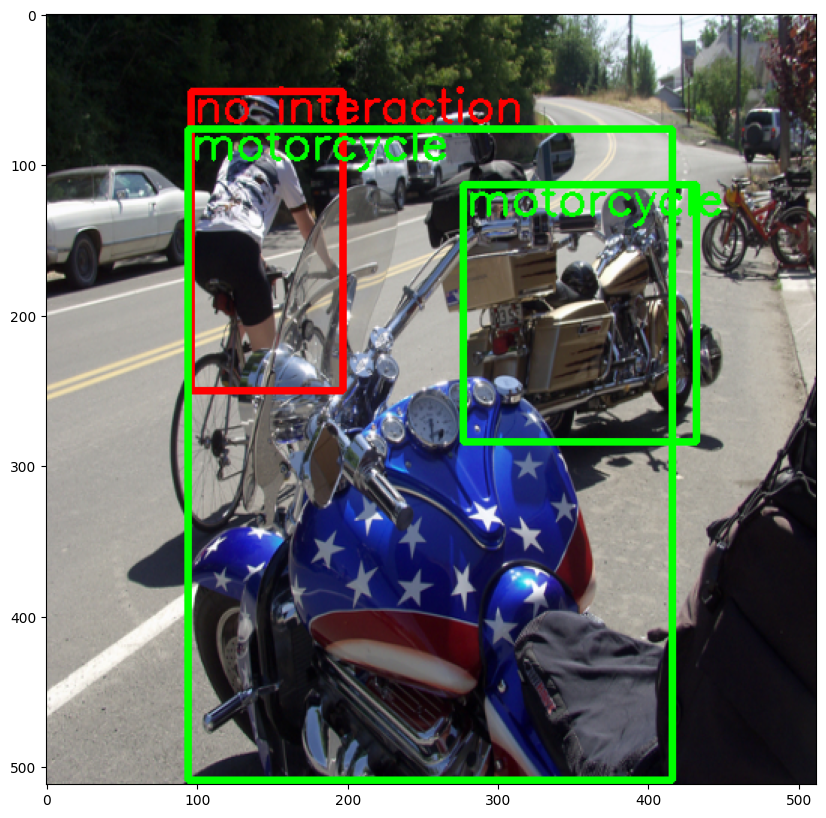

In [36]:
fp.seek(lineid_to_offset[7])
image_id, image, label = fp.readline().rstrip("\n").split("\t")
image = Image.open(BytesIO(base64.urlsafe_b64decode(image))).convert("RGB")
w, h = image.size
w_resize_ratio = task.cfg.patch_image_size / w
h_resize_ratio = task.cfg.patch_image_size / h

boxes_target = {"human_boxes": [], "obj_boxes": [], "hois": [], "objs": [], "human_area": [], "obj_area": [], "size": torch.tensor([h, w])}
label_list = label.strip().split('&&')
for label in label_list:
    human_x0, human_y0, human_x1, human_y1, hoi_id, hoi, obj_x0, obj_y0, obj_x1, obj_y1, obj_id, obj = label.strip().split(',', 12)
    boxes_target["human_boxes"].append([float(human_x0), float(human_y0), float(human_x1), float(human_y1)])
    boxes_target["obj_boxes"].append([float(obj_x0), float(obj_y0), float(obj_x1), float(obj_y1)])
    boxes_target["hois"].append(hoi)
    boxes_target["objs"].append(obj)
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (task.cfg.patch_image_size, task.cfg.patch_image_size))
for i, (human_box, obj_box) in enumerate(zip(boxes_target["human_boxes"], boxes_target["obj_boxes"])):
    print(["<bin_{}>".format(int(pos)) for pos in human_box[:4]])
    print("a person {} a {}".format(boxes_target["hois"][i].replace('_', ' '), boxes_target["objs"][i]))
    print(["<bin_{}>".format(int(pos)) for pos in obj_box[:4]])
    print()
    cv2.putText(
        img,  boxes_target["hois"][i].replace('_', ' '),  (int(human_box[0]*w_resize_ratio)+2, int(human_box[1]*h_resize_ratio)+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2, color=(0, 0, 255),
    )
    cv2.rectangle(
        img, (int(human_box[0]*w_resize_ratio), int(human_box[1]*h_resize_ratio)), (int(human_box[2]*w_resize_ratio), int(human_box[3]*h_resize_ratio)), (0, 0, 255), 3
    )
    cv2.putText(
        img,  boxes_target["objs"][i], (int(obj_box[0]*w_resize_ratio)+2, int(obj_box[1]*h_resize_ratio)+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2, color=(0, 255, 0),
    )
    cv2.rectangle(
        img, (int(obj_box[0]*w_resize_ratio), int(obj_box[1]*h_resize_ratio)), (int(obj_box[2]*w_resize_ratio), int(obj_box[3]*h_resize_ratio)), (0, 255, 0), 3
    )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

What are the interactions in the image?
torch.Size([1, 3, 512, 512])
tensor([58644, 58551, 58836, 58959,    10,   621,   946, 58615, 58667, 58864,
        59131,    10, 14678,     4, 58644, 58551, 58836, 58959,    10,   621,
         7031, 33151, 58615, 58667, 58864, 59131,    10, 14678,     4,     2],
       device='cuda:0')
a person hold a bicycle. a person straddle a bicycle. <bin_187> <bin_94> <bin_379> <bin_502> <bin_158> <bin_210> <bin_407> <bin_674> <bin_187> <bin_94> <bin_379> <bin_502> <bin_158> <bin_210> <bin_407> <bin_674> 
hold ['<bin_187>', '<bin_94>', '<bin_379>', '<bin_502>']bicycle. ['<bin_158>', '<bin_210>', '<bin_407>', '<bin_674>']
straddle ['<bin_187>', '<bin_94>', '<bin_379>', '<bin_502>']bicycle. ['<bin_158>', '<bin_210>', '<bin_407>', '<bin_674>']


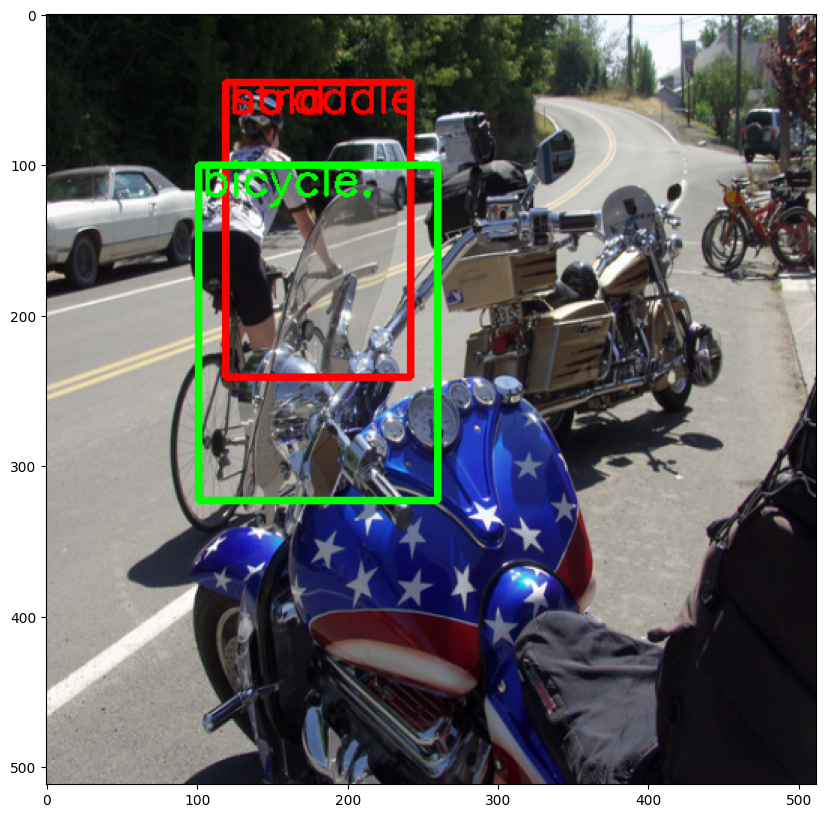

In [37]:
human_list = ['person']

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (task.cfg.patch_image_size, task.cfg.patch_image_size))
# Construct input sample & preprocess for GPU if cuda available
instruction = f'What are the interactions in the image?'
print(instruction)
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
print(sample['net_input']['patch_images'].shape)

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    print(hypos[0][0]["tokens"])
    tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
print(tokens, bins, imgs)
tokens = tokens.split()
bins = bins.split()
# for i in range(int(len(bins)/4)):
j = 0
for i, token in enumerate(tokens):
    if token == 'a':
        if tokens[i+1] == 'person':
            bin = bins[4*j:4*(j+1)]
            j += 1
            coord_list = bin2coord(' '.join(bin), w_resize_ratio, h_resize_ratio)
            cv2.putText(
                img, 
                tokens[i+2], 
                (int(coord_list[0])+2, int(coord_list[1])+20),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                thickness=2,
                color=(0, 0, 255),
                )
            cv2.rectangle(
                img,
                (int(coord_list[0]), int(coord_list[1])),
                (int(coord_list[2]), int(coord_list[3])),
                (0, 0, 255),
                3
            )
            print(tokens[i+2], bin, end='')
        elif tokens[i+1].endswith('.'):
            bin = bins[4*j:4*(j+1)]
            j += 1
            coord_list = bin2coord(' '.join(bin), w_resize_ratio, h_resize_ratio)
            cv2.putText(
                img, 
                tokens[i+1], 
                (int(coord_list[0])+2, int(coord_list[1])+20),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                thickness=2,
                color=(0, 255, 0),
                )
            cv2.rectangle(
                img,
                (int(coord_list[0]), int(coord_list[1])),
                (int(coord_list[2]), int(coord_list[3])),
                (0, 255, 0),
                3
            )
            print(tokens[i+1], bin)
        
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()